In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam


/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load the data

In [3]:
fake_news=pd.read_csv("ML KNN Overview Fake.txt", header=None)
true_news=pd.read_csv("ML KNN Overview Real.txt", header=None)

In [4]:
fake_news

,0
0,trump warns of vote flipping on machines
1,this election is not about trump its about a g...
2,more on trump populism and how it can be contr...
3,trump bollywood ad meant to sway indian americ...
4,dems could be up on charges for inciting trump...
...,...
1293,what happens if trump loses the election what ...
1294,latest poll shows trump with 4 point lead in f...
1295,breaking donald trump makes major clinton indi...
1296,no hate crimes have not intensified since trum...


## Set the columns name 'text'

In [5]:
fake_news.columns=['text']
true_news.columns=['text']

In [6]:
true_news['label']=1
fake_news['label']=0

## Combine the dataset

In [7]:
news_df=pd.concat([fake_news,true_news])

In [8]:
# Shuffle the dataset
news_df = news_df.sample(frac=1).reset_index(drop=True)

In [9]:

# Preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

news_df['text'] = news_df['text'].apply(preprocess_text)

## Spliting the data

In [10]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(news_df['text'], news_df['label'], test_size=0.2, random_state=42)

## Vectorization

In [11]:
vectorizer= TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define function to plot training history


In [16]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'],label='Training loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'],label='Training Accuracy')
    plt.plot(history.history['val_acc'],label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.show()

In [17]:
# Function to plot ROC curve
def plot_roc_curve(y_test,y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test,y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
# Function to evaluate models
def evaluate_model(model, X_trai,y_train,X_test,y_test):
    model.fit(X_trai,y_train)
    y_pred=model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:,1]
    
    accuracy=accuracy_score(y_test,y_pred)
    cm=confusion_matrix(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    
    print(f'Accuracy: {accuracy}')
    print('Confusion Matrix')
    print(cm)
    print(f'Report of Confusion Matrix')
    print(report)
    plot_roc_curve(y_test,y_pred_prob)

## Logistic Regression 

Logistic Regression
Accuracy: 0.8119266055045872
Confusion Matrix
[[198  74]
 [ 49 333]]
Report of Confusion Matrix
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       272
           1       0.82      0.87      0.84       382

    accuracy                           0.81       654
   macro avg       0.81      0.80      0.80       654
weighted avg       0.81      0.81      0.81       654



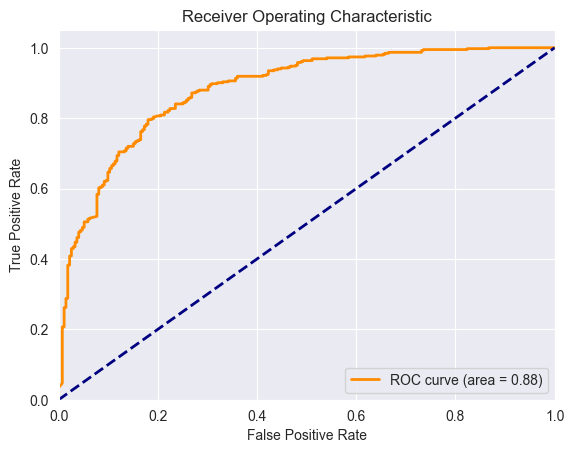

In [19]:
print("Logistic Regression")
logreg=LogisticRegression(max_iter=1000)
evaluate_model(logreg,X_train_tfidf,y_train,X_test_tfidf,y_test)